In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle
curves = pickle.load(open('curves.pkl', 'rb'))

In [3]:


for row in curves:
    x = np.array(row['curve']['x']) / 100.
    y = np.array(row['curve']['y']) / 100.
    dx = np.concatenate([[0], np.diff(row['curve']['x'])], 0) / 10.
    dy = np.concatenate([[0], np.diff(row['curve']['y'])], 0) / 10.
    dt = np.concatenate([[0], np.diff(row['curve']['t'])], 0) / 10.
    
    row['curve_features'] = np.stack([x, y, dx, dy, dt], -1)
    
    row['curve']['dt'] = dt
    

In [4]:
from sklearn.cross_validation import train_test_split
train_curves, val_curves = train_test_split(curves, test_size=0.1, random_state=42)


/home/jheuristic/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


лесная


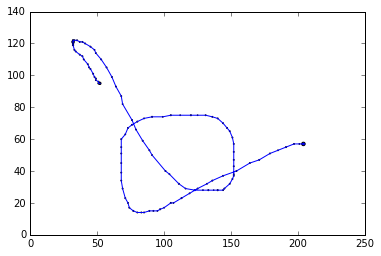

In [5]:
i=10
curve = curves[i]['curve']
print(curves[i]['word'])

plt.plot(curve['x'], curve['y'])
plt.scatter(curve['x'], curve['y'], 
             s=curve['dt'])

In [6]:
tokens = sorted(list(set(' '.join(curve['word'] for curve in curves))))

EOS = ';'
assert EOS not in tokens
tokens = [None, EOS] + tokens + [None] #make sure EOS is 1-st to make it tfnn-familiar


token_to_id = {t:i for i, t in enumerate(tokens)}
print("n_tokens =", len(tokens))

EOS_ix = token_to_id[EOS]
BLANK_ix = len(tokens) - 1


n_tokens = 38


In [7]:
def to_matrix(lines, max_len=None,  dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or (max(map(len, lines)) + 1)
    lines_ix = np.full([len(lines), max_len], EOS_ix, dtype=dtype)

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        line_ix.append(EOS_ix)
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [8]:
_dummy_curves = [x['word'] for x in train_curves[:5]]
print(_dummy_curves)
to_matrix(_dummy_curves)

['этапах', 'ориентацию', 'атс', 'боится', 'глядеть']


array([[33, 22,  4, 19,  4, 25,  1,  1,  1,  1,  1],
       [18, 20, 12,  9, 17, 22,  4, 26, 12, 34,  1],
       [ 4, 22, 21,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 5, 18, 12, 22, 21, 35,  1,  1,  1,  1,  1],
       [ 7, 15, 35,  8,  9, 22, 32,  1,  1,  1,  1]], dtype=int32)

In [9]:
NUM_FEATURES = row['curve_features'].shape[1]

In [10]:
curve_to_array = lambda curve: np.stack([curve[c] for c in curve_features], -1)

def generate_batch(curves, batch_size=None, replace=False):
    if batch_size is not None:
        curves = [curves[i] for i in np.random.choice(len(curves), batch_size, replace=replace)]
        
    words = [x['word'] for x in curves]
    
    words_ix = to_matrix(words)
    features = [x['curve_features'] for x in curves]
    swipe_lengths = np.array(list(map(len, features)), dtype='int32')
    
    features_matrix = np.zeros([len(features), max(swipe_lengths), NUM_FEATURES], 'float32')
    for i, swipe in enumerate(features):
        features_matrix[i, :len(swipe)] = swipe
    
    return features_matrix, swipe_lengths, words_ix
    

In [11]:
_dummy_swipe, _dummy_swipe_len, _dummy_target_ix = generate_batch(train_curves, batch_size=3)

### Architecture

In [12]:
%env CUDA_VISIBLE_DEVICES=1
import tensorflow as tf
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, 
                                                   allow_soft_placement=True,
                                                   log_device_placement=True))

env: CUDA_VISIBLE_DEVICES=1


In [13]:
from tfnn.ops.basic import infer_length
swipe_ph = tf.placeholder_with_default(_dummy_swipe, [None, None, NUM_FEATURES])
swipe_len_ph = tf.placeholder_with_default(_dummy_swipe_len, [None])
reference_answers = tf.placeholder_with_default(_dummy_target_ix, [None, None])

swipe_mask = tf.sequence_mask(swipe_len_ph, maxlen=tf.shape(swipe_ph)[1], dtype=tf.float32)
ref_len = infer_length(reference_answers, EOS_ix)
ref_mask = tf.sequence_mask(ref_len, maxlen=tf.shape(reference_answers)[1], dtype=tf.float32)

In [14]:
import keras
from keras.models import Sequential
import keras.layers as L
keras.backend.set_session(sess)

model = Sequential([
    L.InputLayer((None, NUM_FEATURES)),
    L.GRU(256, return_sequences=True),
    L.Dense(len(tokens))
])

logits = model(swipe_ph)

Using TensorFlow backend.


In [15]:
import tensorflow as tf
from tfnn.ops.basic import infer_mask


def compute_ctc_loss(logits, logits_length, out_ref, eos_ix=1,
                     force_blanks_after_eos=True):
    """
    Computes CTC loss function for each sequence in batch
    :param logits: translation logits, tensor float32[batch, time, voc_size]
    :param logits_length: logit sequence lengths, tensor int[batch]
    :param eos_ix: id of end-of-sequence. MAKE SURE IT IS CORRECT
    :param force_blanks_after_eos: if True, forces blanks
    :returns: differentiable CTC loss, float32[batch_size]
    """
    assert logits.shape[-1] is not None

    # blank is now the last token
    blank_index = tf.cast(logits.shape[-1], out_ref.dtype)

    if force_blanks_after_eos:
        # make sure reference labels after first EOS are blanks
        out_mask = infer_mask(out_ref, eos_ix, dtype=out_ref.dtype)
        out_ref = out_ref * out_mask + tf.fill(tf.shape(out_ref), blank_index) * (1 - out_mask)
    # cast labels to sparse
    # [0,0], [0,1], ..., [1,0], [1,1], ... [batch_size, max_length]
    out_ref_indices = tf.where(infer_mask(out_ref, eos_ix))
    out_ref_values = tf.gather_nd(out_ref, out_ref_indices)
    out_ref_sparse = tf.SparseTensor(out_ref_indices, out_ref_values,
                                     dense_shape=tf.cast(tf.shape(out_ref), 'int64'))

    out_ref_sparse = tf.cast(out_ref_sparse, dtype='int32')

    return tf.nn.ctc_loss(labels=out_ref_sparse,
                          inputs=logits,
                          sequence_length=logits_length,
                          preprocess_collapse_repeated=False,
                          ctc_merge_repeated=True,
                          time_major=False, )


def translate(logits, logits_length,pad_ix=1,
              decoder=tf.nn.ctc_greedy_decoder, **kwargs):
    """
    Infers output sequence from logits trained with ctc loss
    :param logits: translation logits, tensor float32[batch, time, voc_size]
    :param logits_length: logit sequence lengths, tensor int[batch]
    :param pad_ix: pads with this value after sequence end
    :param decoder: tf.nn.ctc_greedy_decoder, tf.nn.ctc_beam_search_decoder or similar function.
        Used as decoder(logits_time_major, logits_length, merge_repeated, **kwargs)[0][0]
    :param kwargs: any parameters passed to decoder
    :return: sequence of translation token ids, int[batch, time]
    """

    logits_time_major = tf.transpose(logits, [1, 0, 2])

    # sparse int [batch, time]
    trans_sparse = decoder(
                         logits_time_major,
                         logits_length,
                         merge_repeated=True,
                         **kwargs)[0][0]

    trans = tf.sparse_tensor_to_dense(trans_sparse, default_value=pad_ix)
    return trans

In [16]:
loss = compute_ctc_loss(logits, swipe_len_ph, reference_answers, eos_ix=EOS_ix)
loss = tf.reduce_mean(loss)

In [17]:
step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [18]:
from IPython.display import clear_output
import pandas as pd
ewma = lambda x, span=10: pd.ewma(np.asarray(x), span=span)
history = []
sess.run(tf.global_variables_initializer())


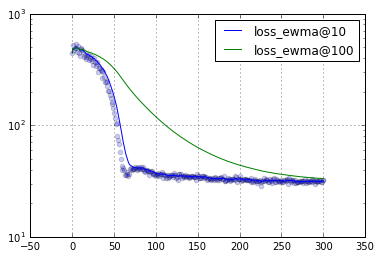

31.751144


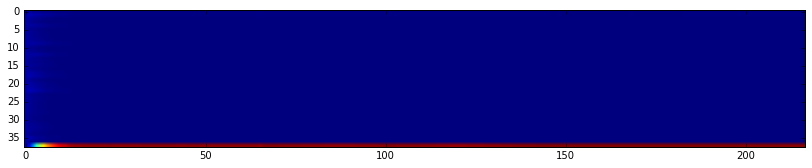

  0%|          | 397/1000000 [07:55<332:36:45,  1.20s/it]

KeyboardInterrupt: 

In [19]:
from tqdm import trange
for i in trange(1000000):
    feed = dict(zip((swipe_ph, swipe_len_ph, reference_answers),
                            generate_batch(train_curves, batch_size=128),))
    
    loss_t = sess.run([loss, step], feed)[0]
    history.append(loss_t)
    
    if i % 100 == 0:
        clear_output(True)
        plt.scatter(np.arange(len(history)), history, alpha=0.2)
        plt.plot(ewma(history, span=10), label='loss_ewma@10')
        plt.plot(ewma(history, span=100), label='loss_ewma@100')
        plt.legend(loc='best')
        plt.yscale('log')
        plt.grid()
        plt.show()
        print(np.mean(history[-100:]))
        plt.figure(figsize=[14,4])
        _p, _len = sess.run([tf.nn.softmax(logits), swipe_len_ph], feed)
        plt.imshow(_p[0, :_len[0]].T)
        plt.show()


In [ ]:
translate(logits, tf.to_int32(swipe_len_ph), pad_ix=EOS_ix, decoder=tf.nn.ctc_greedy_decoder ).eval(feed)[0]

In [ ]:
translate(logits, tf.to_int32(swipe_len_ph), pad_ix=EOS_ix, decoder=tf.nn.ctc_beam_search_decoder ).eval(feed)[0]

In [ ]:
reference_answers.eval(feed)[0]

In [ ]:
[tokens[i] for i in _265[0]]

In [ ]:
plt.imshow(tf.nn.softmax(logits).eval()[0][:20])

In [ ]:
translate(logits, tf.to_int32(swipe_len_ph), pad_ix=EOS_ix, decoder=tf.nn.ctc_beam_search_decoder ).eval()

In [ ]:
curve